In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
!pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.5 MB/s 


In [3]:
### IMPORT SPEKTRAL CLASSES ###

from spektral.utils import *
from spektral.models import gcn
#from spektral.layers import GraphConv
from spektral.layers import GCSConv

# Prepare the data

In [4]:
data=pd.read_csv('./data.csv', delimiter=',', skiprows=0) 

In [5]:
new_data = pd.DataFrame(index=range(0,len(data)),columns=['A','B','C','D','E','G'])
for i in range(len(data)):
  new_data['A'][i]=data[data.columns[0]][i]
  new_data['B'][i]=data[data.columns[1]][i]
  new_data['C'][i]=data[data.columns[2]][i]
  new_data['D'][i]=data[data.columns[3]][i]
  new_data['E'][i]=data[data.columns[4]][i]
  new_data['G'][i]=data[data.columns[6]][i]
new_data=new_data.transpose()  

In [28]:
import numpy as np

# Sequence Lenght  20  
sequence_length = 20*6



def get_timespan(df, today, days):    
    new_df=df.loc[:,today-days:today-1]
    return new_df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    all_sequence = all_sequence.astype(np.float32)
    
    group_store = all_sequence.reshape((-1,1, seq_len))
    group_store_c = all_sequence.reshape((1,-1, seq_len))
   
    #print(group_store[0].shape)
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store_c], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features
def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1,1))  

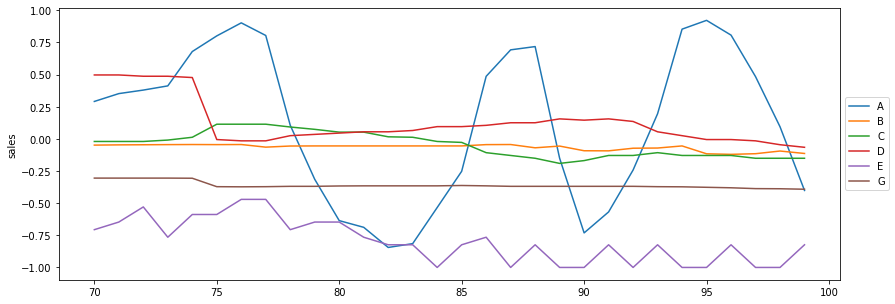

In [29]:
### PLOT A SEQUENCE OF 100 values ###


sequence = get_timespan(new_data, 100, 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Split Data into Train / Valid / Test

In [30]:
train=int(len(new_data.columns)*0.75)
valid=train+int(len(new_data.columns)*0.15)
test=len(new_data.columns)

# CREATE TRAIN FEATURES

In [31]:
### CREATE TRAIN FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.RangeIndex(sequence_length,train)):
    seq_, corr_, feat_ = create_features(new_data, d, sequence_length)
    y_ = create_label(new_data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
print(len(y))    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
Y_train = np.concatenate(y, axis=0).astype('float16')
#Y=np.array(y).reshape(len(y),)
print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, Y_train.shape)

  5%|▌         | 5848/110668 [00:08<02:37, 666.71it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 110668/110668 [02:47<00:00, 660.93it/s]


110668
(664008, 240, 1) (110668, 6, 6) (664008, 1, 7) (664008, 1)


In [32]:
# Check for NaN Values
where_are_NaNs = np.isnan(X_train_cor)
X_train_cor[where_are_NaNs] = 0

# CREATE VALID FEATURES

In [33]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.RangeIndex(train,valid)):
    seq_, corr_, feat_ = create_features(new_data, d, sequence_length)
    y_ = create_label(new_data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
   
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
Y_valid = np.concatenate(y, axis=0).astype('float16')
#Y=np.array(y).reshape(len(y),)
print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, Y_valid.shape)

  0%|          | 0/22181 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 22181/22181 [00:34<00:00, 641.86it/s]


(133086, 240, 1) (22181, 6, 6) (133086, 1, 7) (133086, 1)


In [34]:
# Check for NaN Values 
where_are_NaNs = np.isnan(X_valid_cor)
X_valid_cor[where_are_NaNs] = 0

# CREATE TEST FEATURES

In [35]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.RangeIndex(valid,test)):
    seq_, corr_, feat_ = create_features(new_data, d, sequence_length)
    y_ = create_label(new_data, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
   
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
Y_test = np.concatenate(y, axis=0).astype('float16')
#Y=np.array(y).reshape(len(y),)
print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, Y_test.shape)

  0%|          | 0/14789 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 14789/14789 [00:23<00:00, 641.23it/s]


(88734, 240, 1) (14789, 6, 6) (88734, 1, 7) (88734, 1)


In [36]:
# Check for NaN Values 
where_are_NaNs = np.isnan(X_test_cor)
X_test_cor[where_are_NaNs] = 0

In [37]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

# OBTAIN LAPLACIANS FROM CORRELATIONS

In [38]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

X_train_lap=X_train_lap[:,0].reshape(-1,1,1)
X_valid_lap=X_valid_lap[:,0].reshape(-1,1,1)
X_test_lap=X_test_lap[:,0].reshape(-1,1,1)

# Multivariate Forecasting Model Architecture

In [40]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(sequence_length):
    
    set_seed(33)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    inp_seq = Input((sequence_length, 1))
    inp_lap = Input((1, 1))
    inp_feat = Input((1,7))

    x = GraphConv(1024, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(512, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    #xx = LSTM(128, activation='relu', return_sequences=True)(xx)
    xx = LSTM(64, activation='relu')(xx)
    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    #x = Dense(512, activation='relu')(x)
    #x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [42]:
model = get_model(sequence_length)
model.summary() 


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1, 7)]       0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1, 1)]       0           []                               
                                                                                                  
 graph_conv_6 (GraphConv)       (None, 1, 1024)      8192        ['input_12[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 240, 1)]     0           []                         

# Model Training

In [ ]:
import tensorflow as tf
es = EarlyStopping(patience=25, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model = get_model(sequence_length)
model.fit([X_train_seq, X_train_lap, X_train_feat], Y_train, epochs=150, batch_size=1028, validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], Y_valid), callbacks=[es], verbose=1)



# Load The Pretrained Model


In [45]:

import tensorflow as tf
from spektral_gcn import GraphConv
model = tf.keras.models.load_model('bestRes.h5', custom_objects={'GraphConv': GraphConv})

# Model Evaluation 
## Evaluation Metric  : Root Mean Square Error (RMSE)

In [46]:
# Model Testing 
# test model on test Dataset
pred_test_all = np.zeros(Y_test.shape)
pred_test_all = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


In [47]:
# Model Evaluation 
# Mean absolute error of all the Features 
reverse_test = Y_test
error = np.sqrt(mean_squared_error(reverse_test, pred_test_all))
print( error )

0.045336768


In [50]:
### RMSE ON TEST DATA ###

error = {}

for feat in range(6):
    
    error[feat] = np.sqrt(mean_squared_error(reverse_test.reshape(-1,6,1)[:,feat,:], pred_test_all.reshape(-1,6,1)[:,feat,:]))
# calcul RMSE for each Feature
print(error )     

{0: 0.042938806, 1: 0.0080488315, 2: 0.026130836, 3: 0.017810423, 4: 0.0960431, 5: 0.014131535}


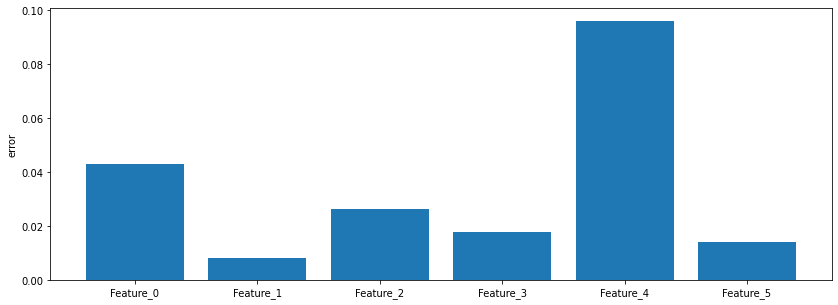

In [51]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(6), error.values())
plt.xticks(range(6), ['Feature_'+str(s) for s in range(6)])
plt.ylabel('error')
np.set_printoptions(False)

In [52]:
### UTILITY FUNCTION TO PLOT PREDICTION ###

def plot_predictions(y_true, y_pred, feat):
    
    y_true = y_true.reshape(-1,6,1)
    y_pred = y_pred.reshape(-1,6,1)
    
    plt.plot(y_true[:,feat,:], label='true')
    plt.plot(y_pred[:,feat,:], label='prediction')
    plt.title(f"feature: {feat} "); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')

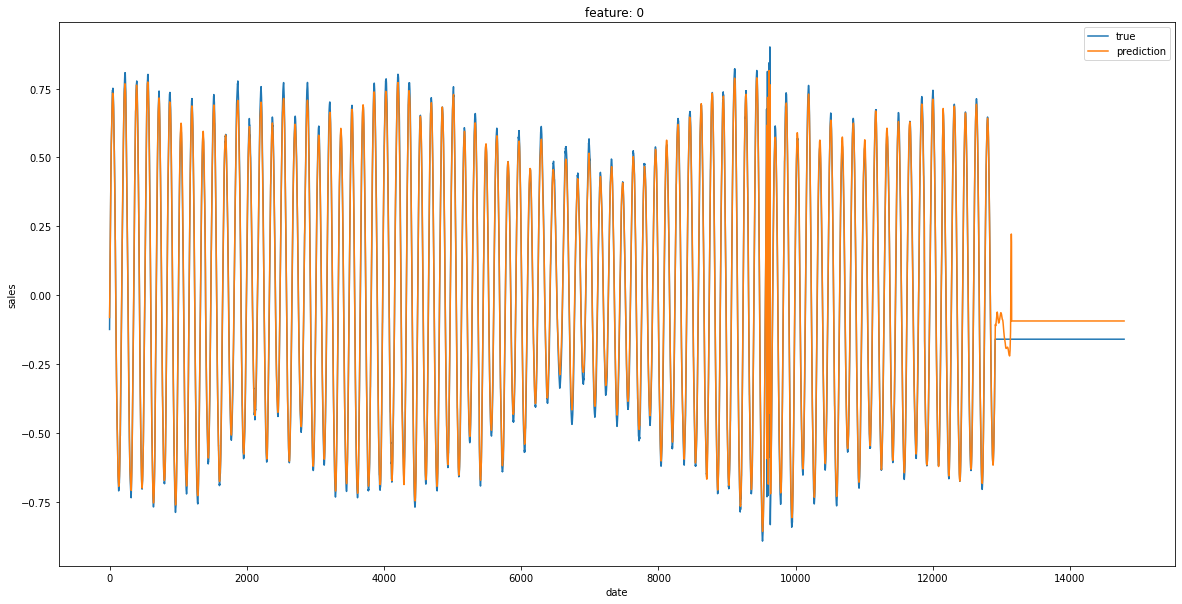

In [53]:
plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,0)

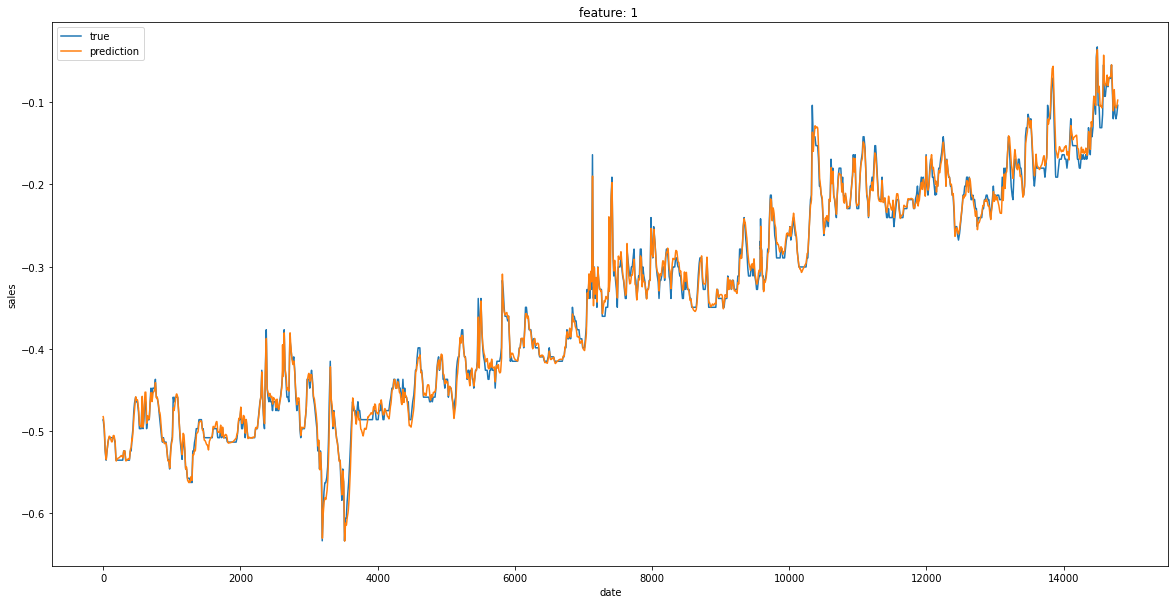

In [54]:
plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,1)

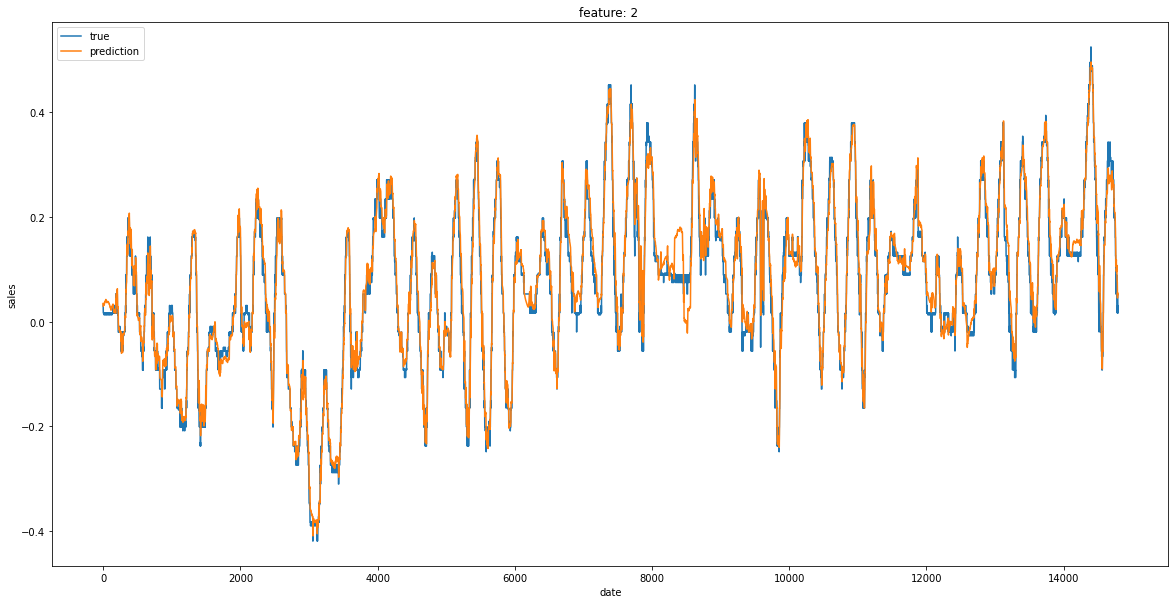

In [55]:
plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,2)

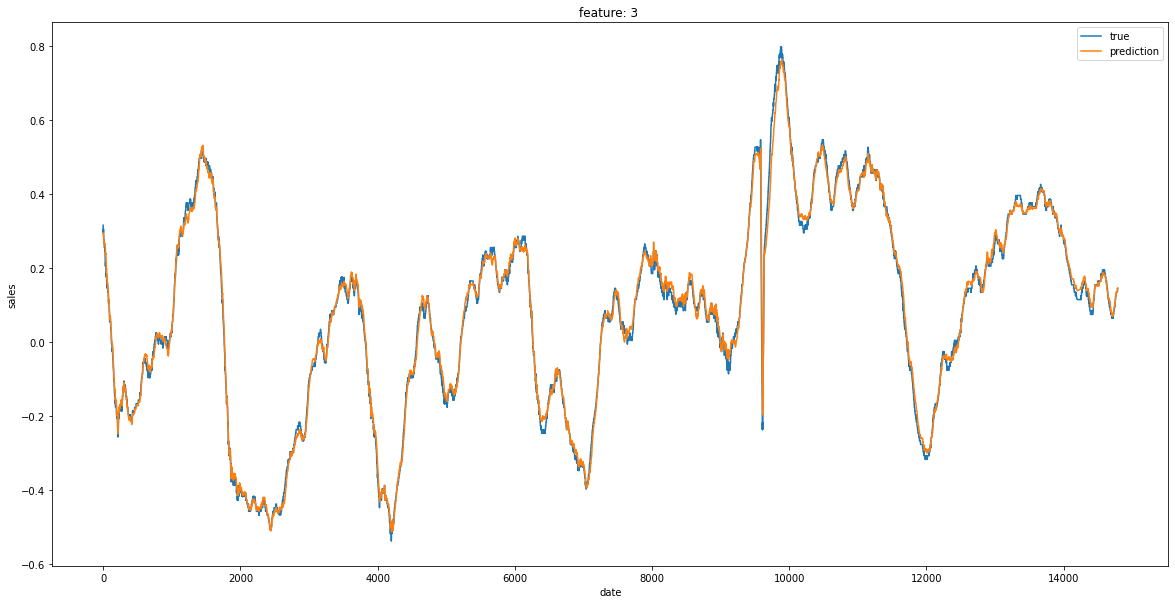

In [56]:
plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,3)

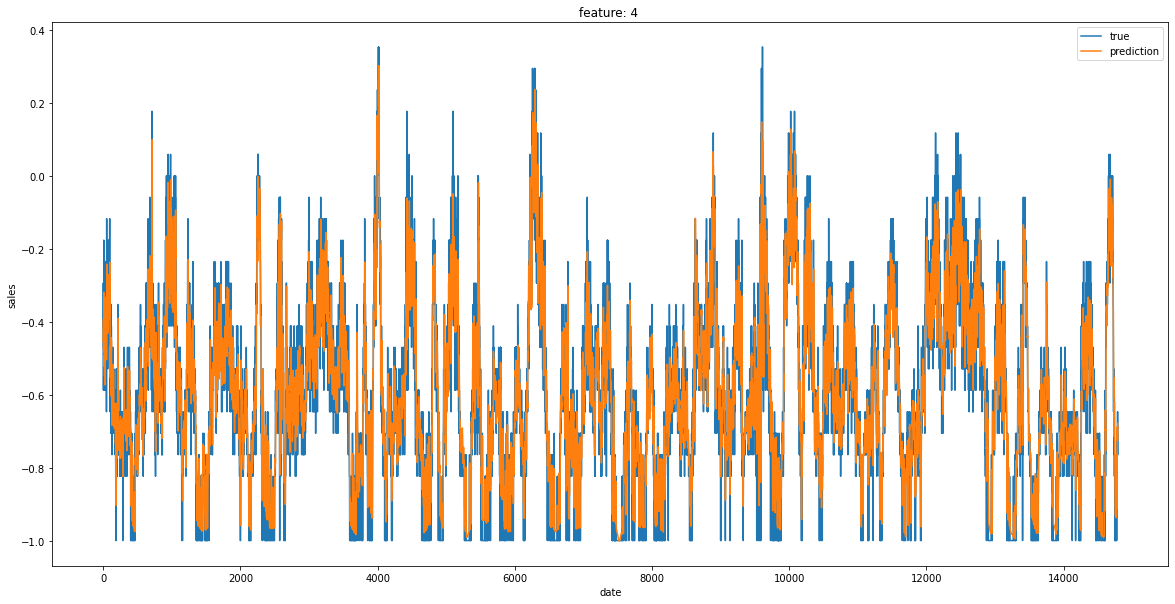

In [57]:
plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,4)

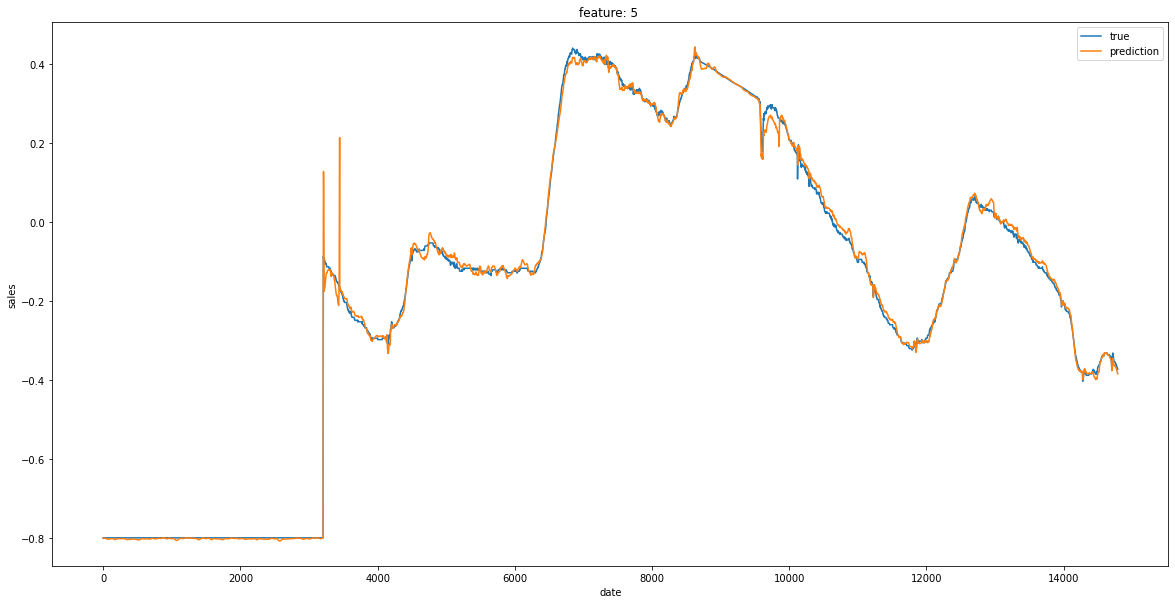

In [58]:

plt.figure(figsize=(20,10))
plot_predictions(reverse_test, pred_test_all,5)
